In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
import json
import functools as ft


import numpy as np

import matplotlib.pyplot as plt
import subprocess
import copy

## Compact geometry for graphene: Open geometry

Here we will use a more compact layout for the graphene structure, which we may call "brick-wall" structure.

To see that this structure indeed make sense, we can take the slide 9 in the slides "Graph_representation", squeeze the hexagon along the y-direction to make it a square. This will give us a "brick-wall" structure. Further, we rotate the brick-wall structure by 90 degrees so that it can fit into Aquila's geometry constraint when we consider the periodic boundary condition with crossing and copy gadgets. This is shown below. 

In [49]:
def brick_wall_graphene_obc(N1, N2, ax=3e-6, ay=2e-6):
    """
    A brick wall structure for the graphene, with N1*N2 unit cells in total. Hence
    there are in total 2 * N1 * N2 variables of interest. We will use additional 
    (3N1N2-N1-N2) atoms for the negative coupling, hence there are in total (5N1N2-N1-N2)
    atoms for the brick wall structure in the open boundary condition. 
    
    ax, ay are the atom spacings along the x and y direction 
    """
    
    
    coords = []
    
    # Add the 2 * N1 * N2 variables
    for n1 in range(N1):
        for n2 in range(N2):
            cell_center_x = 2*ax * (n1 + n2)
            cell_center_y = 2*ay * (n1 - n2)
            coords.append([cell_center_x-ax, cell_center_y])
            coords.append([cell_center_x+ax, cell_center_y])
#             coords.append([cell_center_x, cell_center_y-ay])
#             coords.append([cell_center_x, cell_center_y+ay])
        
#     # Add the auxilliary atoms
#     coords_row_1 = [[n2 * ax, -n2 * ay] for n2 in range(2*N2-1)]
#     coords_row_2 = [[ax + n2 * 2 * ax, ay -n2 * 2 * ay] for n2 in range(N2)]    
#     for n1 in range(N1):
#         coords += list(np.array(coords_row_1) + [n1*2*ax, n1*2*ay])    
#         if n1 < N1-1:
#             coords += list(np.array(coords_row_2) + [n1*2*ax, n1*2*ay])
    
    # Get the register based on the coordinates
    register = AtomArrangement()
    for coord in coords:
        register.add(coord)
        
    return register

def visualize_brick_wall_graphene(
    register, 
    N1, 
    N2, 
    xtick = 6e-6,
    ytick = 4e-6,
    show_atom_index=False, 
    blockade_radius: float=0.0, 
    draw_bond=True, 
    x_size=12, 
    y_size=12
):
    
    all_sites = [site.coordinate for site in register]
    
    sites_var = all_sites[:2*N1*N2]
    sites_aux = all_sites[2*N1*N2:(5*N1*N2-N1-N2)]
    sites_gadgets = all_sites[(5*N1*N2-N1-N2):]
    
    fig = plt.figure(figsize=(x_size, y_size))
    
    plt.plot(np.array(sites_var)[:, 0], np.array(sites_var)[:, 1], 'r.', ms=15, label='variables')
#     plt.plot(np.array(sites_aux)[:, 0], np.array(sites_aux)[:, 1], 'b.', ms=10, label='aux. atoms')
    
    if len(sites_gadgets) > 0:
        plt.plot(np.array(sites_gadgets)[:, 0], np.array(sites_gadgets)[:, 1], 'g.', ms=10, label='gadget atoms')    
    
    if blockade_radius > 0 and draw_bond:
        for i in range(len(all_sites)):
            for j in range(i+1, len(all_sites)):            
                dist = np.linalg.norm(np.array(all_sites[i]) - np.array(all_sites[j]))
                if dist <= blockade_radius:
                    plt.plot([all_sites[i][0], all_sites[j][0]], [all_sites[i][1], all_sites[j][1]], 'k')

    if show_atom_index:
        for idx, site in enumerate(register):
            plt.text(*site.coordinate, f"  {idx}", fontsize=12)        
    
    x_min = min(graphene.coordinate_list(0))
    x_max = max(graphene.coordinate_list(0))
    y_min = min(graphene.coordinate_list(1))
    y_max = max(graphene.coordinate_list(1))
    
    plt.xticks(np.arange(x_min, x_max, xtick/3))
    plt.yticks(np.arange(y_min, y_max, ytick/2))
    
    plt.gca().set_aspect('equal')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.show()
    

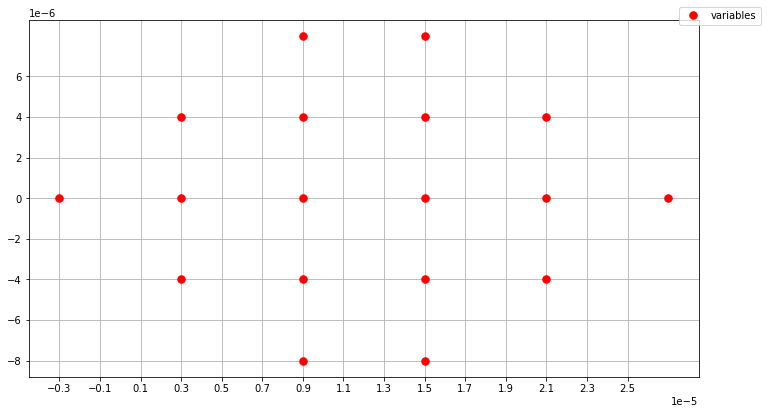

In [50]:
N1, N2 = 3, 3
blockade_radius = 3e-6
show_atom_index=False
graphene = brick_wall_graphene_obc(N1, N2)
visualize_brick_wall_graphene(graphene, N1, N2, blockade_radius=blockade_radius, show_atom_index=show_atom_index)

In [32]:
[max(graphene.coordinate_list(1)), min(graphene.coordinate_list(1))]

[3.9999999999999996e-05, -3.9999999999999996e-05]

In [33]:
[max(graphene.coordinate_list(0)), min(graphene.coordinate_list(0))]

[6.3e-05, -3e-06]